In [1]:
# LIBS
from feature_extractors import main_fe
import pydub
import numpy as np
import torch
from matplotlib import pyplot as plt
from ml_pipeline.model_manager import ModelManager
from pydub import AudioSegment

c:\Users\shace\Documents\GitHub\snore_detector\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
parameters = {'axes.labelsize': 10,
              'axes.titlesize': 10,
              'figure.figsize': [20, 20],
              'figure.subplot.hspace': 0.15,
              'figure.subplot.wspace': 0.15}
plt.rcParams.update(parameters)

In [3]:
# FOURIER PARAMS
WIN_LEN = 30  # ms
HOP_LEN = 10  # ms
N_FFT = 1024
SR = 16  # khz

In [52]:
# CHOOSE THIS
fe = main_fe.MelSpec_FE(sample_rate=SR * 1000,
                                   win_length=WIN_LEN * SR,
                                   n_fft=N_FFT,
                                   hop_length=HOP_LEN * SR,
                                   n_mels=80)

In [26]:
# OR THIS
fe = main_fe.MFCC_FE(sample_rate=SR * 1000,
                                win_length=WIN_LEN * SR,
                                n_fft=N_FFT,
                                hop_length=HOP_LEN * SR,
                                n_mels=32)

In [4]:
# OR THIS
fe = main_fe.Raw_FE()

In [15]:
# SPECIFY PATH TO AUDIO
audios = [
    "test_mic_audios/snore4.wav",
    "test_mic_audios/voice.wav",
    "test_mic_audios/snore2.wav",
    "test_mic_audios/loud_inhale.wav",
    "test_mic_audios/loud_exhale.wav",
    "audio_data/kaggle_snore2/0.wav",
    "test_mic_audios/snore.wav",
    "test_mic_audios/snore3.wav",
    "test_mic_audios/real_snore.wav",
    "test_mic_audios/00001476-100507_mic_snore_292.wav",
    r"C:\Users\shace\Documents\GitHub\snore_detector\SnoreActivityDetector\audio_data\greek_mic_snore_only_clear\00001016-100507_mic_snore_59.wav"
]

In [16]:
# SPECIFY WINDOW (FROM - TO)
WINDOW_START = 0
WINDOW_END = 1000

In [17]:
#  https://stackoverflow.com/a/66922265
def pydub_to_pt(audio: pydub.AudioSegment):
    """
    Converts pydub audio segment into np.float32 of shape [duration_in_seconds*sample_rate, channels],
    where each value is in range [-1.0, 1.0]. 
    Returns tuple (audio_np_array, sample_rate).
    """
    return torch.tensor(np.array(audio.get_array_of_samples(), dtype=np.float32).reshape((-1, audio.channels)) / (
            1 << (8 * audio.sample_width - 1))).permute(-1, -2)

In [18]:
# LOADING AUDIO
audios = {el: pydub_to_pt(pydub.AudioSegment.from_wav(el).set_channels(1)[WINDOW_START : WINDOW_END]) for el in audios}

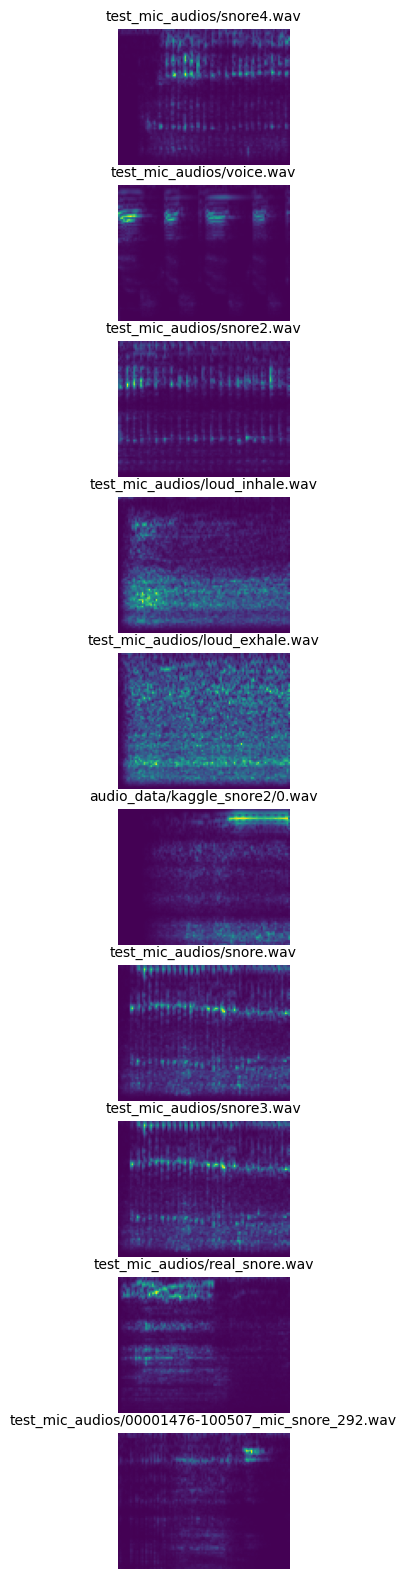

In [53]:
cols = 1
_, axes = plt.subplots(nrows=len(audios), ncols=cols)
for ax, k in zip(axes.flat, audios):
    ax.imshow(fe(audios[k]).squeeze(0))

    ax.set(
        title=f"{k}")
    ax.axis('off')
plt.show()

In [22]:
model_manager = ModelManager(model_name="M5_greek_clear")
model = model_manager.get_model()
model.to("cpu")
model.eval()

2023-10-08 08:02:55,988:    Model 'M5_greek_clear' have been found


M5Net(
  (conv1): Sequential(
    (0): Conv1d(1, 40, kernel_size=(160,), stride=(16,))
    (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(40, 40, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(40, 80, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv1d(80, 80, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, t

In [20]:
def eq(inp, target_dbfs):
    inputs_ndim = len(inp.shape)
    rms = torch.sqrt(torch.mean(inp ** 2, dim=inputs_ndim - 1, keepdim=True))
    rms = torch.clamp(rms, 1e-10, 1e10)

    wave_dBFS = 20 * torch.log10(rms)
    dBFS_diff = target_dbfs - wave_dBFS

    return inp * (10 ** (dBFS_diff / 20))

In [21]:
with torch.no_grad():
    preds = {k: torch.softmax(model(torch.unsqueeze(fe(eq(v, -20)), 0)), dim=-1) for k, v in audios.items()}
preds

{'test_mic_audios/snore4.wav': tensor([[0.7372, 0.1121, 0.1507]]),
 'test_mic_audios/voice.wav': tensor([[0.0633, 0.8432, 0.0935]]),
 'test_mic_audios/snore2.wav': tensor([[0.8722, 0.0834, 0.0444]]),
 'test_mic_audios/loud_inhale.wav': tensor([[0.6586, 0.2804, 0.0609]]),
 'test_mic_audios/loud_exhale.wav': tensor([[0.8753, 0.0986, 0.0260]]),
 'audio_data/kaggle_snore2/0.wav': tensor([[0.6537, 0.2841, 0.0622]]),
 'test_mic_audios/snore.wav': tensor([[0.8070, 0.1091, 0.0839]]),
 'test_mic_audios/snore3.wav': tensor([[0.8064, 0.1090, 0.0845]]),
 'test_mic_audios/real_snore.wav': tensor([[0.4302, 0.2205, 0.3493]]),
 'test_mic_audios/00001476-100507_mic_snore_292.wav': tensor([[0.3978, 0.4512, 0.1510]]),
 'C:\\Users\\shace\\Documents\\GitHub\\snore_detector\\SnoreActivityDetector\\audio_data\\greek_mic_snore_only_clear\\00001016-100507_mic_snore_59.wav': tensor([[0.0997, 0.1715, 0.7288]])}

In [4]:
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

sound = AudioSegment.from_file("snore.wav")
normalized_sound = match_target_amplitude(sound, -40.0)
normalized_sound.export("snore3.wav", format="wav")

<_io.BufferedRandom name='snore3.wav'>

In [ ]:
with torch.no_grad():
    preds = {k: model(torch.unsqueeze(fe(v), 0)) for k, v in audios.items()}
preds